In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['C:\\Users\\Roman\\Desktop\\GitBamt\\BAMT', 'C:\\Users\\Roman\\Desktop\\GitBamt', 'C:\\Users\\Roman\\Desktop\\GitBamt\\BAMT\\tutorials']


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%%time
import BAMT.Networks as Nets
import BAMT.Preprocessors as pp

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

Wall time: 5.46 s


In [4]:
hack = pd.read_csv(r'../Data/hack_processed_with_rf.csv')

In [5]:
hack.sample(5)

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,...,Period,Lithology,Gross,Netpay,Porosity,Permeability,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
68,BRAVO DOME,TUBB,USA,NORTH AMERICA,SIERRA GRANDE UPLIFT,COMPRESSION,36.0049,-103.8177,BP,ONSHORE,...,PERMIAN,SANDSTONE,75.0,36.0,20.0,42.0,NaN,NaN,NaN,0.80
393,SHATLYK,SHATLYK (SHATLYK EAST),TURKMENISTAN,FORMER SOVIET UNION,AMU DARYA,COMPRESSION,37.3900,61.1000,TURKMENGAS,ONSHORE,...,CRETACEOUS,SANDSTONE,44.4,18.9,21.8,222.0,775.342466,NaN,NaN,0.84
27,AUK,ROTLIEGEND (AUK),UK,EUROPE,NORTH SEA CENTRAL,EXTENSION,56.4125,2.0286,SHELL,OFFSHORE,...,PERMIAN,SANDSTONE,294.0,252.0,19.0,5.0,834.808260,NaN,NaN,NaN
369,REDWATER,LEDUC,CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.6500,-113.3333,IMPERIAL OIL RESOURCES,ONSHORE,...,DEVONIAN,LIMESTONE,240.0,30.0,8.0,100.0,849.849850,NaN,NaN,NaN
467,WEMBLEY,HALFWAY,CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,55.2197,-119.1749,BP AND OTHERS,ONSHORE,...,TRIASSIC,SANDSTONE,24.0,6.6,10.2,60.0,801.699717,0.2,NaN,NaN


In [6]:
hack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Field name                  514 non-null    object 
 1   Reservoir unit              514 non-null    object 
 2   Country                     514 non-null    object 
 3   Region                      514 non-null    object 
 4   Basin name                  514 non-null    object 
 5   Tectonic regime             442 non-null    object 
 6   Latitude                    514 non-null    float64
 7   Longitude                   514 non-null    float64
 8   Operator company            514 non-null    object 
 9   Onshore/offshore            514 non-null    object 
 10  Hydrocarbon type            514 non-null    object 
 11  Reservoir status            514 non-null    object 
 12  Structural setting          514 non-null    object 
 13  Depth                       514 non

In [7]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
hack = hack[cols]

In [8]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(hack)

In [9]:
discretized_data.sample(5)

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
77,0,4,11,10,2,2,3,4,0
139,0,21,11,2,0,0,3,1,0
179,5,15,15,11,3,4,4,3,0
349,2,12,11,6,3,4,4,4,2
18,5,9,12,3,0,2,0,1,0


## Group1 algorithm

In [10]:
bn = Nets.HybridBN(has_logit=True, use_mixture=True)
d = p.info

In [11]:
bn.add_nodes(d)
bn.add_edges(discretized_data, scoring_function=('MI',))

In [12]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,ConditionalLogit,disc,"[cont, disc, disc]","[Depth, Structural setting, Lithology]"
2,Lithology,ConditionalLogit,disc,"[cont, disc]","[Netpay, Structural setting]"
3,Structural setting,Logit,disc,[cont],[Permeability]
4,Gross,MixtureGaussian,cont,[cont],[Porosity]
5,Netpay,MixtureGaussian,cont,[cont],[Permeability]
6,Porosity,ConditionalMixtureGaussian,cont,[disc],[Tectonic regime]
7,Permeability,MixtureGaussian,cont,[cont],[Gross]
8,Depth,MixtureGaussian,cont,[cont],[Gross]


In [13]:
bn.plot('Test1')

2021-12-28 19:08:14,579 | ERROR    | Networks.py-plot-0206 | This version allows only html format.


In [25]:
bn.plot('Simple.html')

## Group1. Params

In [26]:
print(bn.nodes)

[Tectonic regime, Period, Lithology, Structural setting, Gross, Netpay, Porosity, Permeability, Depth]


In [28]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross']}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('init_nodes.html')

In [29]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
         'white_list': [('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')]}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('whihe_list.html')

In [30]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
          'init_edges':[('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')],}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('init_edges.html')

In [31]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
          'init_edges':[('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')],
         'remove_init_edges':True}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('remove_init.html')

## Sampling

In [32]:
bn.sample(10)

2021-12-28 19:10:01,196 | ERROR    | Networks.py-sample-0174 | Parameter learning wasn't done. Call fit_parameters method


In [34]:
bn_1 = Nets.HybridBN(has_logit=True, use_mixture=True)
d = p.info
bn_1.add_nodes(d)

In [35]:
bn_2 = Nets.HybridBN(has_logit=True, use_mixture=True)
d = p.info
bn_2.add_nodes(d)

In [36]:
from pgmpy.estimators import K2Score
bn_1.add_edges(discretized_data, scoring_function=('MI',))
bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [37]:
%%time
bn_1.fit_parameters(hack)

Wall time: 19.3 s


In [38]:
%%time
bn_2.fit_parameters(hack)

Wall time: 38.4 s


In [39]:
predictions_mi = bn_1.sample(514, as_df=True)
predictions_k2 = bn_2.sample(514, as_df=True)

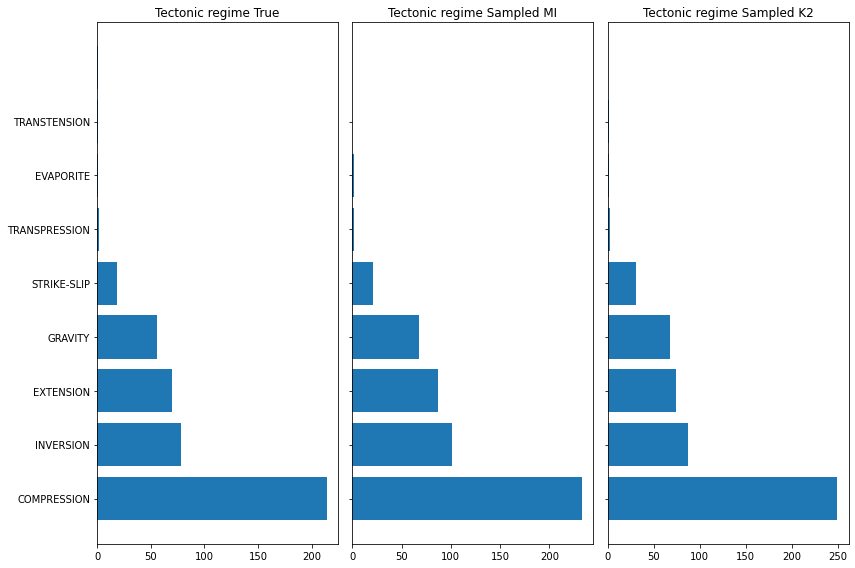

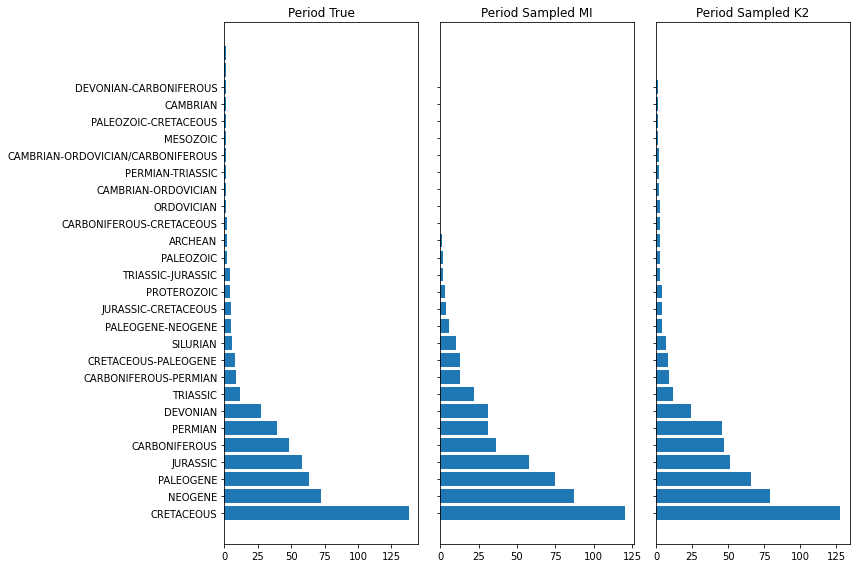

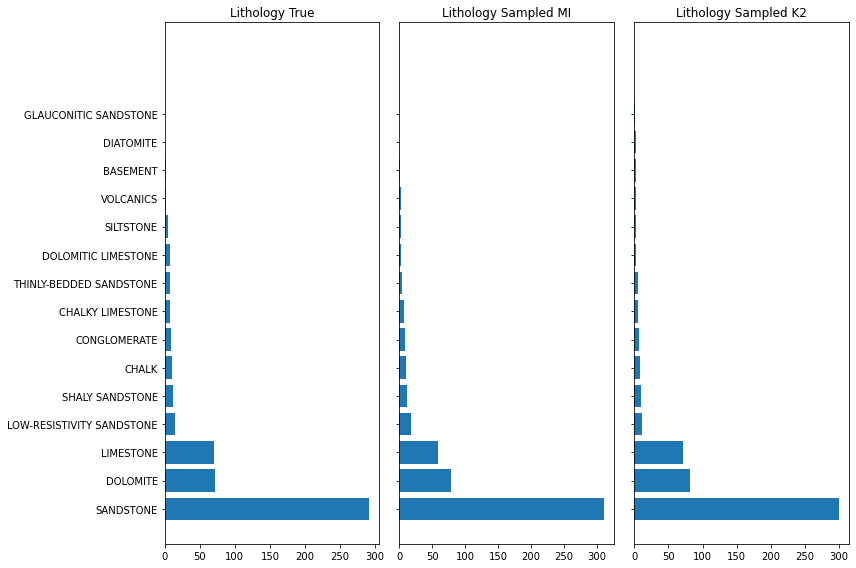

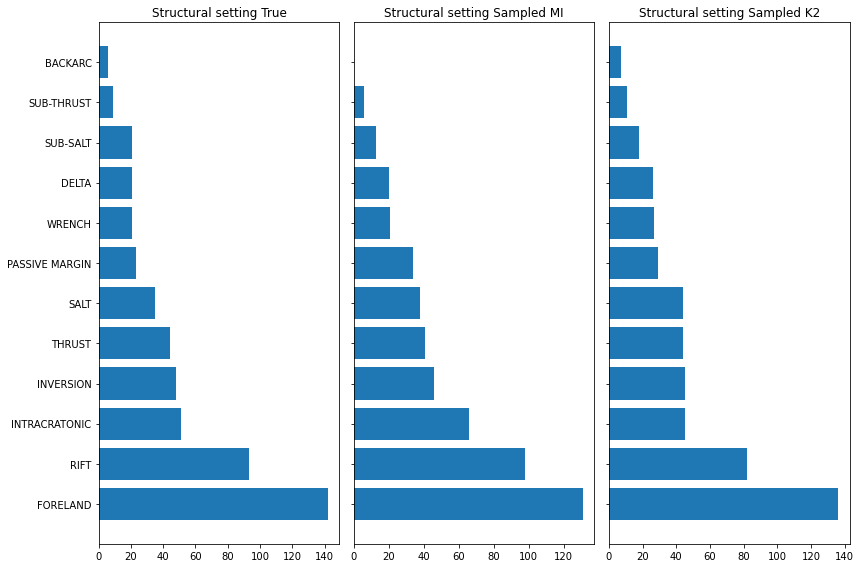

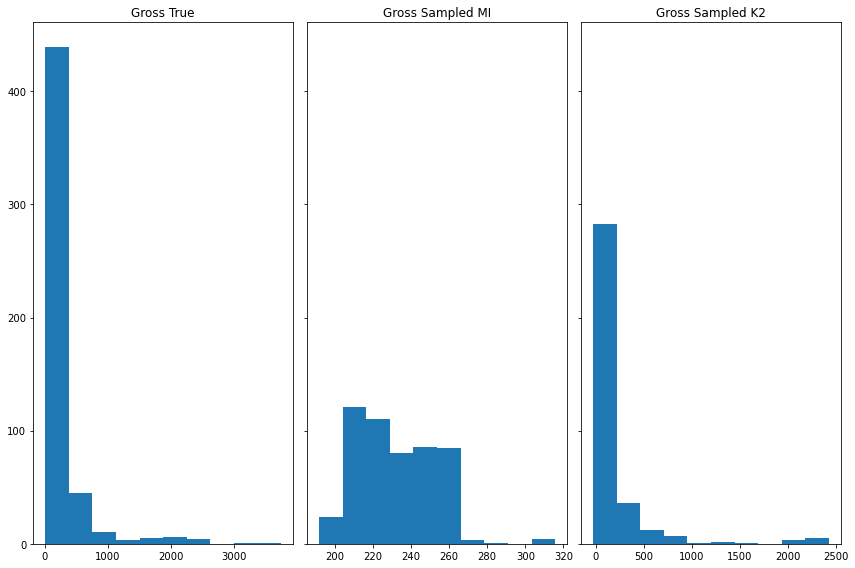

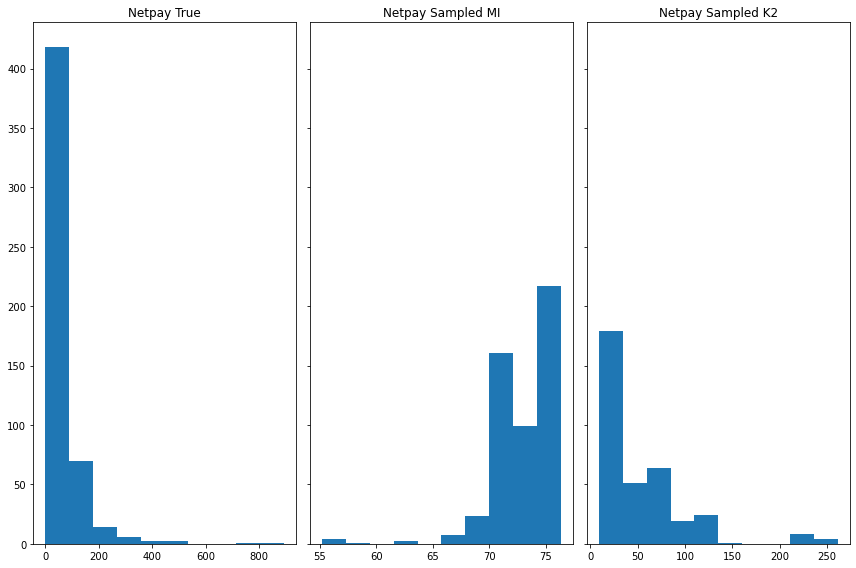

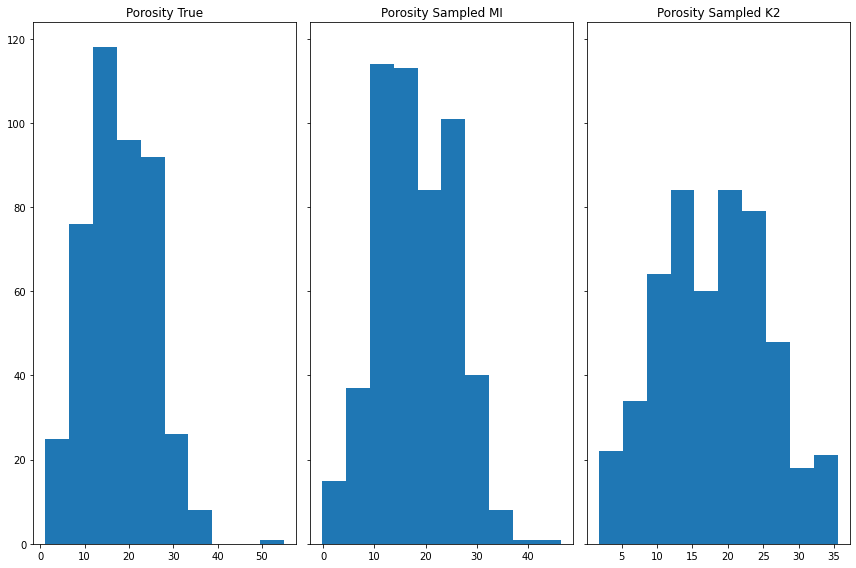

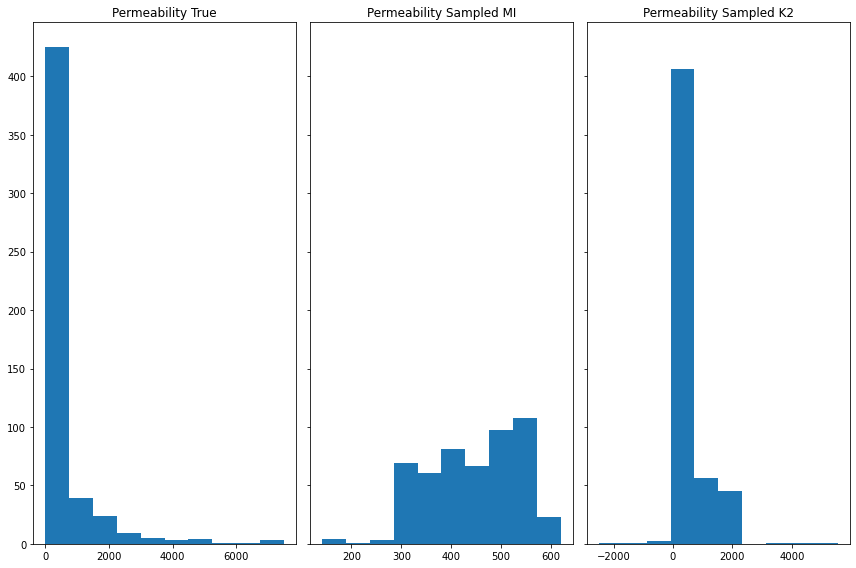

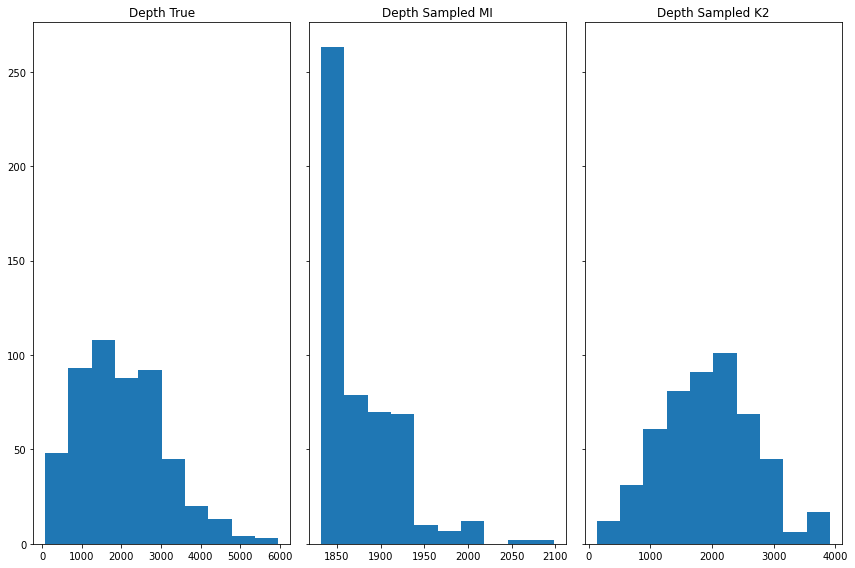

In [40]:
for column in hack.columns.to_list():
    fig, ax = plt.subplots(1,3, figsize=(12,8), sharey=True)
    if hack[column].dtype.name in ['float64']:
        ax[0].hist(hack[column].values)
        ax[1].hist(predictions_mi[column].values)
        ax[2].hist(predictions_k2[column].values)
    else:
        ax[0].barh(hack[column].value_counts().index, hack[column].value_counts().values)
        ax[1].barh(predictions_mi[column].value_counts().index, predictions_mi[column].value_counts().values)
        ax[2].barh(predictions_k2[column].value_counts().index, predictions_k2[column].value_counts().values)
    ax[0].set_title(f'{column} True')
    ax[1].set_title(f'{column} Sampled MI')
    ax[2].set_title(f"{column} Sampled K2")
    
    plt.tight_layout()